In [1]:
import pandas as pd
from gensim.models import FastText

C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/Ignored.h5", key="Ignored")

In [3]:
model_sent = FastText.load("../models/user_level/fasttext_Ignored_senti.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [6]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
   
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [7]:
# Calculate frequencies for the male and female terms

woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [8]:
woman_terms_freq, man_terms_freq

([['woman', 'she', 'hers', 'girl', 'daughter', 'her', 'female', 'sister'],
  [20940, 49480, 121, 7479, 2584, 14340, 2431, 1562]],
 [['he', 'man', 'boy', 'his', 'male', 'brother', 'son'],
  [73969, 22062, 2863, 21133, 2880, 1860, 2584]])

In [9]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [10]:
# Calculate the weighted centroid vectors

df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)

Top 10 (woman) ['she', 'her', 'daughter', 'herself', 'sister', 'woman', 'mom', 'wife', 'granddaughter', 'mother']
Top 10 (man) ['he', 'his', 'son', 'say', 'guy', 'himself', 'elon', 'supporter', 'stan', 'would']


# Top 5 terms with the most sentiment for the female and male centroid vectors

In [11]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
145,shit,0.000,0.678,0.294
210,hell,0.020,0.918,0.565
230,hypocritical,0.048,0.740,0.415
151,hater,0.052,0.702,0.422
58,opponent,0.080,0.741,0.716


In [12]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
35,threaten,0.104,0.958,0.590
176,shout,0.229,0.925,0.444
210,hell,0.020,0.918,0.565
235,stealing,0.086,0.913,0.455
96,desperation,0.125,0.904,0.419


In [13]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
19,president,0.677,0.622,0.973
127,winning,0.955,0.712,0.972
162,presidential,0.612,0.656,0.972
242,commissioner,0.602,0.449,0.949
33,chairman,0.656,0.567,0.933


In [14]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
99,afraid,0.010,0.775,0.245
183,unfaithful,0.031,0.806,0.298
204,psycho,0.039,0.922,0.560
46,wrath,0.039,0.908,0.548
119,horrified,0.040,0.885,0.368


In [15]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
34,threaten,0.104,0.958,0.590
151,arrest,0.146,0.951,0.500
245,bang,0.265,0.951,0.740
313,murder,0.061,0.942,0.615
204,psycho,0.039,0.922,0.560


In [16]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
224,force,0.612,0.750,0.905
102,policeman,0.542,0.708,0.898
215,teacher,0.760,0.404,0.885
244,prince,0.888,0.464,0.870
115,doctor,0.700,0.531,0.861


# Pretesting the distribution of the sentiment scores 

In [17]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.05316508501934914 0.026848982572786513 0.03457188525569435


In [18]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.06816607762357298 0.034701836958954825 0.024650418031786053


In [19]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df[subject]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("Kolmogorov–Smirnov test:", stats.kstest(df[subject],
               stats.norm.cdf))

## Visualization of the QQ-Plot based on https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0


Bad key figure.labelsize in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


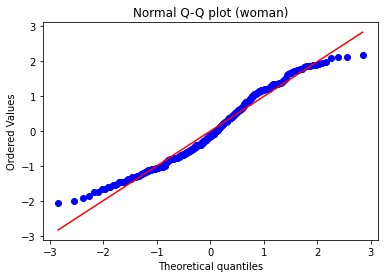

Kolmogorov–Smirnov test: KstestResult(statistic=0.5786037454820314, pvalue=3.084771167301513e-100)


In [20]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

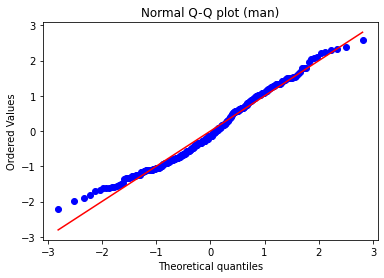

Kolmogorov–Smirnov test: KstestResult(statistic=0.5862499611757495, pvalue=2.063913163570626e-91)


In [21]:
check_normal_dist(df_NRC_man, "arousal","man")

# Testing for statistical significance with Welsh's t-test

In [22]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    from scipy.stats import levene 
    import math
    import statistics
    print(score_type)
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
        if df_1[score_type].mean() > df_2[score_type].mean():
            print(f"Average {score_type} for female terms is bigger:", df_1[score_type].mean(), ">" , df_2[score_type].mean())
        else:
            print(f"Average {score_type} for male terms is bigger:", df_2[score_type].mean(), ">" , df_1[score_type].mean())
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print( "Cohens D:", d)
    print("Amount female terms:", len(df_1), ", Amount male terms:", len(df_2))
    print("------------------------------")

In [23]:
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

valence
Statistics=-1.376225, p=0.169
Same distribution (fail to reject H0)
Amount female terms: 314 , Amount male terms: 278
------------------------------
arousal
Statistics=1.401293, p=0.162
Same distribution (fail to reject H0)
Amount female terms: 314 , Amount male terms: 278
------------------------------
dominance
Statistics=-3.044326, p=0.002
Different distributions (reject H0)
Average dominance for male terms is bigger: 0.553338129496403 > 0.5099777070063696
Cohens D: -0.2519798748960161
Amount female terms: 314 , Amount male terms: 278
------------------------------
